In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from src.utils import create_dataset, plot_matrix, compare_matrix, plot_matrix_cv
from sklearn.model_selection import KFold
from src.models.kernels import LambdaRBF, ARD_gpflow
from src.models.models import GPRLasso, SVGPLasso
from src.models.validation import measure_mnll, measure_rmse, kfold_cv_model
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split

2023-05-12 10:10:45.005645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generate a toy dataset given a specific precision matrix

In [25]:
def fill_lowrank_triangular(vect, dim, length) -> tf.Tensor:
    """
    Create lowrank matrix from vector 

    Args:
        vect (tensor) : tensor of float 
        (parameters of a lowrank full Gaussian kernel)
        dim (int) : dimension of the inputs (higher value)
        length (int) : number of parameters
    
    Returns:
        matrix M that is shaped dim x len(vect) / dim
    """
    if length % dim != 0:
        raise ValueError("Dimension mismatch!")
    
    lowrank_matrix = tf.reshape(vect,[dim, int(length / dim)])
    return lowrank_matrix
def init_lowrank_precision(dim, rank) -> tf.Tensor:
    """
    Initializes full gaussian kernel with random precision

    Args:
        dim (int) : dimension of the precision matrix (dim x dim)
        rank (int) : rank of the precision matrix

    Returns:
        Cholesky decomposition of the precision in vector format
    """
    full_L = np.random.uniform(-1,1,(dim,dim))
    P = full_L@np.transpose(full_L)
    lowrank_L = tf.reshape(tfp.math.pivoted_cholesky(P, rank), -1)
    return lowrank_L
L = fill_lowrank_triangular(init_lowrank_precision(5, 4), 20, 20)
L

<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[-0.71343373],
       [-0.7676865 ],
       [-0.47743101],
       [ 0.75507367],
       [-0.52111079],
       [-0.00424254],
       [ 0.92109627],
       [ 0.        ],
       [ 0.21141602],
       [ 1.21197309],
       [ 0.        ],
       [ 0.        ],
       [ 0.79803212],
       [-0.04681155],
       [-0.67557678],
       [-0.01073938],
       [ 1.46413945],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])>

In [2]:
def get_precision_dict(precision, reverse=True):
    precision = np.abs(precision)
    precision_dict = []
    d = precision.shape[0]
    for i in range(d):
        for j in range(d):
            precision_dict.append({'i': i, 'j': j, 'l': precision[i][j]}) if i <= j else None
    return sorted(precision_dict, key=lambda d: d['l'], reverse=reverse) 

In [3]:
def random_diag_precision(D):
    return np.diag(np.random.uniform(0,1,D))
def random_notdiag_precision(D):
    sparsity = 0.5
    precision = np.random.rand(D, D)
    precision[precision < sparsity] = 0
    precision = np.triu(precision) + np.triu(precision, 1).T
    return precision
def random_offdiag_precision(D, random_offdiag='no', n_offdiag=1):
    diag = np.ones(D)
    L = np.diag(diag, 0)
    if n_offdiag > D-1:
        n_offdiag = D-1
    for n in range(n_offdiag):
        i = n+1
        # define the offdiagonal
        if random_offdiag == 'no':
            offdiag = D**0.5 * np.ones(D-i)
        elif random_offdiag == 'uniform':
            offdiag = np.random.uniform(0, 1, D-i)
        elif random_offdiag == 'gaussian':
            offdiag = np.random.normal(-1, 1, D-i)
        # add it to the matrix L
        L += np.diag(offdiag, -i)
    # define the precision matrix
    precision = L @ L.T
    # normalize the precision matrix to have ones on the diagonal
    diag_m = np.diag(1/np.diag(precision))
    return (np.sqrt(diag_m) @ precision) @ np.sqrt(diag_m)

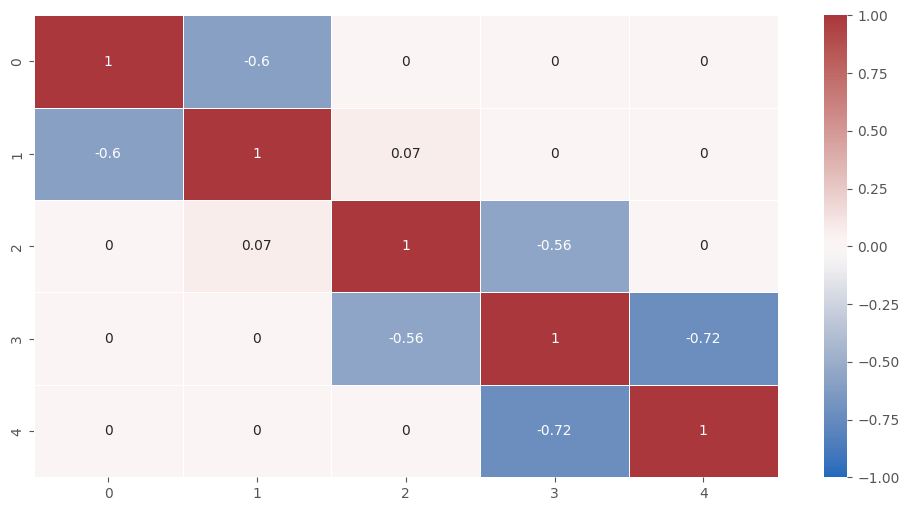

In [4]:
D = 5
precision = random_offdiag_precision(D, random_offdiag='gaussian', n_offdiag=1)
covariance = np.linalg.inv(precision) 
plot_matrix(precision)
#sqrt(diag)*precision*

In [5]:
def generate_dataset(precision, covariance, n=100, kernel_variance=1.0, noise_variance=0.1, random_state=0):
    d = covariance.shape[0]
    # sampling from known covariance 
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
    LRBF = LambdaRBF(variance=kernel_variance, randomized=False, d=d)
    K = LRBF.K_Lambda(X,precision).numpy()
    noise = np.random.normal(0, noise_variance, size=n)
    Y = (np.random.multivariate_normal(np.zeros(n), K, size=1) + noise).reshape(-1,1)
    # train-test split
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # center the dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, shuffle=True)
    Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
    Y_train = (Y_train - Y_train_mean) / Y_train_std
    Y_test = (Y_test - Y_train_mean) / Y_train_std
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = generate_dataset(precision, covariance, noise_variance=0.1, kernel_variance=1, n=1000)

name,class,transform,prior,trainable,shape,dtype,value
GPRLasso.kernel.L,Parameter,Identity,,True,"(15,)",float64,"[0.44721, 0., 0...."
GPRLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPRLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


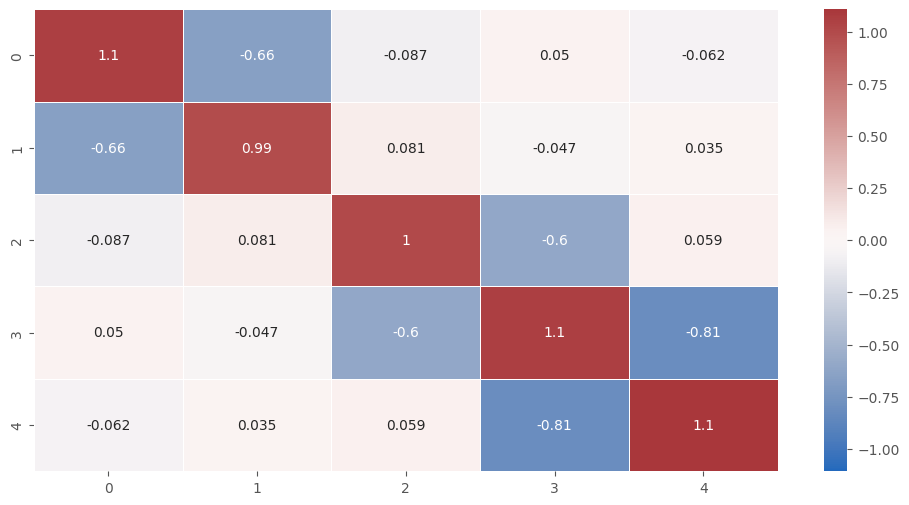

In [8]:
LRBF = LambdaRBF(variance=1.0, randomized=False, d=D)
model_params = {'num_inducing': 100, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 100, 'lasso': 10, 'tol_sparsity': 0.1}
gpr_lasso_LRBF = GPRLasso(data=(X_train, Y_train), kernel=LRBF, lasso=0)
gpflow.utilities.print_summary(gpr_lasso_LRBF, fmt="notebook")
gpr_lasso_LRBF.train()
plot_matrix(gpr_lasso_LRBF.kernel.precision())

In [ ]:
points = []
precision = np.abs(gpr_lasso_LRBF.kernel.precision().numpy())
covariance = np.abs(tf.linalg.inv(gpr_lasso_LRBF.kernel.precision()).numpy())
for i in range(D):
    for j in range(D):
        points.append({'i': i, 'j': j, 'c': covariance[i][j], 'p': precision[i][j]}) if i <= j else None
points

[{'i': 0, 'j': 0, 'c': 5868133832.590575, 'p': 0.06433554729708063},
 {'i': 0, 'j': 1, 'c': 1273544418.637228, 'p': 0.001122441532115929},
 {'i': 0, 'j': 2, 'c': 1808778569.5314672, 'p': 0.2151022459199985},
 {'i': 0, 'j': 3, 'c': 6458198235.636061, 'p': 0.09034798320829028},
 {'i': 0, 'j': 4, 'c': 3409807740.2285023, 'p': 0.16109565249058658},
 {'i': 0, 'j': 5, 'c': 165123356.93277523, 'p': 0.12843592977403312},
 {'i': 1, 'j': 1, 'c': 276400998.26032746, 'p': 0.04179648158526709},
 {'i': 1, 'j': 2, 'c': 392547058.3488013, 'p': 0.14988217968912723},
 {'i': 1, 'j': 3, 'c': 1401605127.1711857, 'p': 0.11008731711393259},
 {'i': 1, 'j': 4, 'c': 740030995.2986286, 'p': 0.1422091632279392},
 {'i': 1, 'j': 5, 'c': 35835764.8944746, 'p': 0.009684733948519887},
 {'i': 2, 'j': 2, 'c': 557540623.8663213, 'p': 1.3154878511947072},
 {'i': 2, 'j': 3, 'c': 1990657163.3348408, 'p': 0.7382514474468825},
 {'i': 2, 'j': 4, 'c': 1051019543.5787039, 'p': 1.099706344334123},
 {'i': 2, 'j': 5, 'c': 50897661.

In [ ]:
points = []
precision = np.abs(gpr_lasso_LRBF.kernel.precision().numpy())
covariance = np.abs(tf.linalg.inv(gpr_lasso_LRBF.kernel.precision()).numpy())
for i in range(D):
    for j in range(D):
        points.append({'i': i, 'j': j, 'c': covariance[i][j], 'p': precision[i][j]}) if i <= j else None
points

[{'i': 0, 'j': 0, 'c': 5868133832.590575, 'p': 0.06433554729708063},
 {'i': 0, 'j': 1, 'c': 1273544418.637228, 'p': 0.001122441532115929},
 {'i': 0, 'j': 2, 'c': 1808778569.5314672, 'p': 0.2151022459199985},
 {'i': 0, 'j': 3, 'c': 6458198235.636061, 'p': 0.09034798320829028},
 {'i': 0, 'j': 4, 'c': 3409807740.2285023, 'p': 0.16109565249058658},
 {'i': 0, 'j': 5, 'c': 165123356.93277523, 'p': 0.12843592977403312},
 {'i': 1, 'j': 1, 'c': 276400998.26032746, 'p': 0.04179648158526709},
 {'i': 1, 'j': 2, 'c': 392547058.3488013, 'p': 0.14988217968912723},
 {'i': 1, 'j': 3, 'c': 1401605127.1711857, 'p': 0.11008731711393259},
 {'i': 1, 'j': 4, 'c': 740030995.2986286, 'p': 0.1422091632279392},
 {'i': 1, 'j': 5, 'c': 35835764.8944746, 'p': 0.009684733948519887},
 {'i': 2, 'j': 2, 'c': 557540623.8663213, 'p': 1.3154878511947072},
 {'i': 2, 'j': 3, 'c': 1990657163.3348408, 'p': 0.7382514474468825},
 {'i': 2, 'j': 4, 'c': 1051019543.5787039, 'p': 1.099706344334123},
 {'i': 2, 'j': 5, 'c': 50897661.

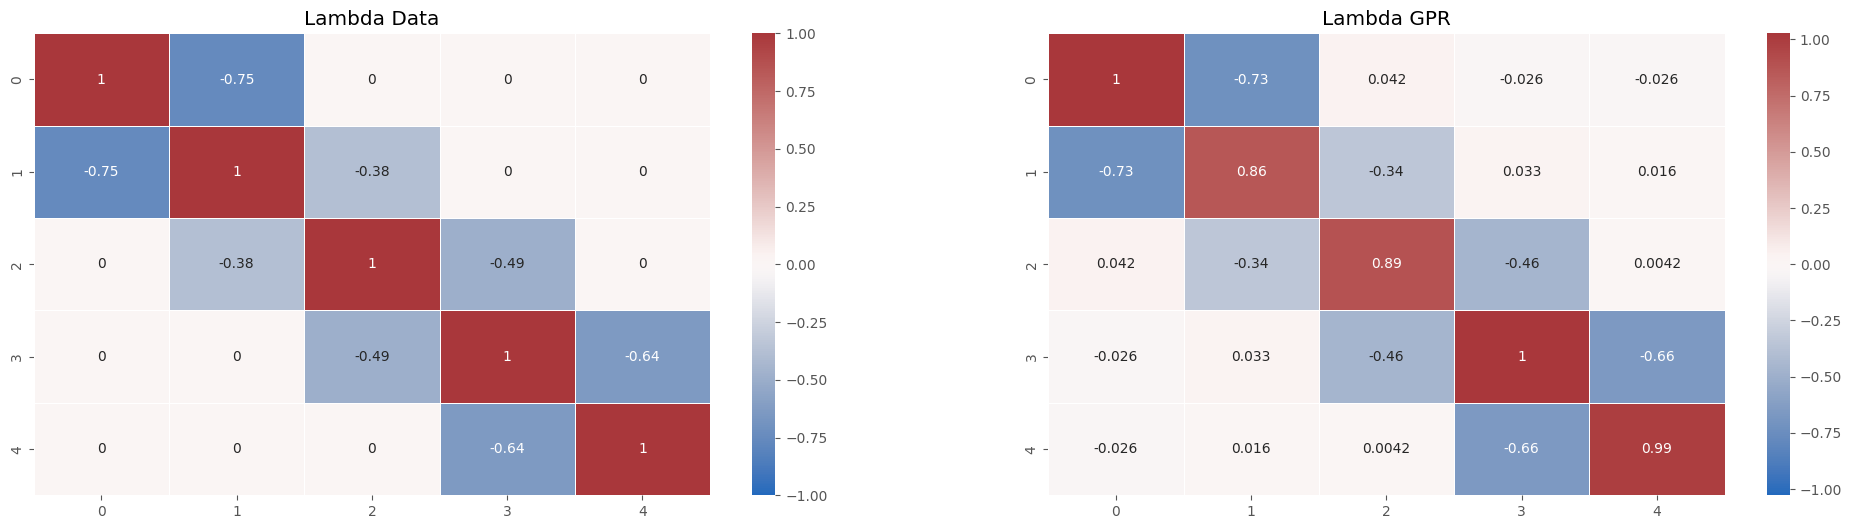

In [7]:
compare_matrix(precision, gpr_lasso_LRBF.kernel.precision(), titles=['Lambda Data', 'Lambda GPR'])

In [140]:
gpr_lasso_LRBF.likelihood.variance

<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.017304744901826156>

name,class,transform,prior,trainable,shape,dtype,value
GPRLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPRLasso.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[2.23607, 2.23607, 2.23607..."
GPRLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


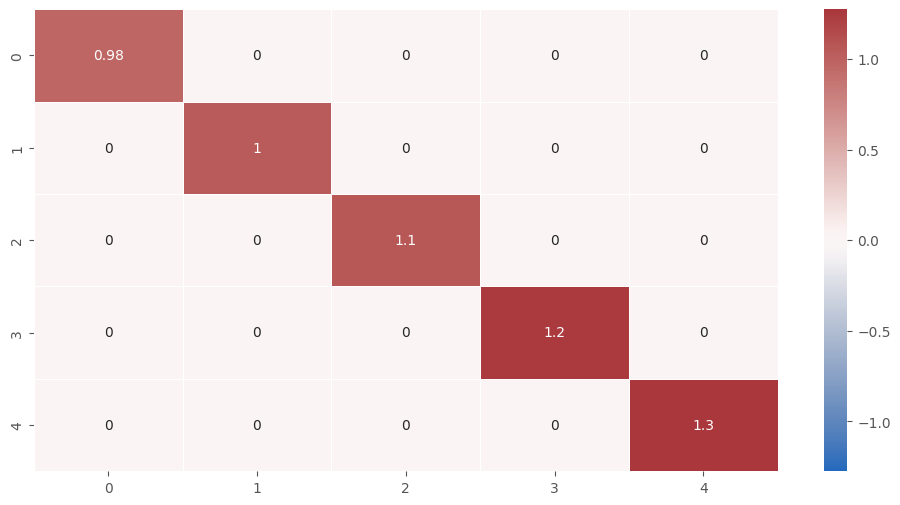

In [7]:
RBF_ARD = ARD_gpflow(variance=1.0, randomized=False, d=D)
gpr_lasso_RBF_ARD = GPRLasso(data=(X_train, Y_train), kernel=RBF_ARD, lasso=0)
gpflow.utilities.print_summary(gpr_lasso_RBF_ARD, fmt="notebook")
gpr_lasso_RBF_ARD.train()
plot_matrix(gpr_lasso_RBF_ARD.kernel.precision())

In [142]:
train_rmse_stan, test_rmse_stan = measure_rmse(gpr_lasso_RBF_ARD, X_train, Y_train, X_test, Y_test)
print('-- RBF ARD --')
print('Train RMSE: %.3f - Test RMSE: %.3f'%(train_rmse_stan, test_rmse_stan))
train_rmse_stan, test_rmse_stan = measure_rmse(gpr_lasso_LRBF, X_train, Y_train, X_test, Y_test)
print('-- RBF Lambda --')
print('Train RMSE: %.3f - Test RMSE: %.3f'%(train_rmse_stan, test_rmse_stan)) 

-- RBF ARD --
Train RMSE: 0.059 - Test RMSE: 0.514
-- RBF Lambda --
Train RMSE: 0.086 - Test RMSE: 0.399


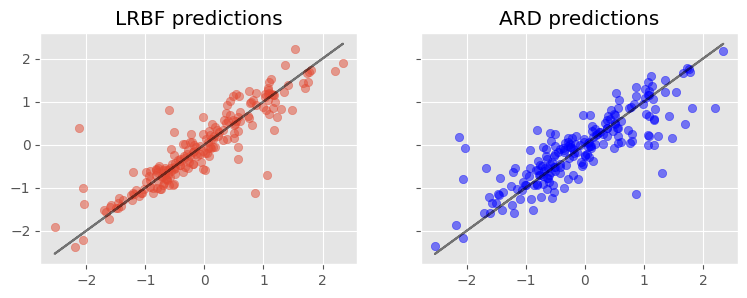

In [143]:
def plot_predicted_actual(model_LRBF, model_ARD, X, Y):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    y_pred_train_LRBF, _ = model_LRBF.predict_f(X)
    y_pred_train_ARD, _ = model_ARD.predict_f(X)
    axs[0].scatter(Y, y_pred_train_LRBF, alpha=0.5)
    axs[0].plot(Y, Y, alpha=0.5, color='black')
    axs[0].set_title('LRBF predictions')
    axs[1].scatter(Y, y_pred_train_ARD, alpha=0.5, color='blue')
    axs[1].plot(Y, Y, alpha=0.5, color='black')
    axs[1].set_title('ARD predictions')
    plt.show()
plot_predicted_actual(gpr_lasso_LRBF, gpr_lasso_RBF_ARD, X_test, Y_test)

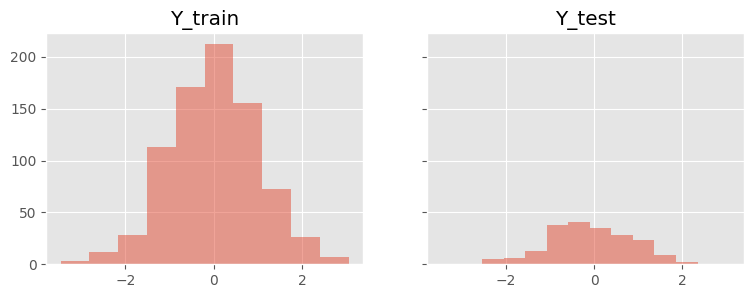

In [144]:
def plot_Y_distributions(Y_train, Y_test):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True, sharex=True)
    axs[0].hist(Y_train, alpha=0.5)
    axs[0].set_title('Y_train')
    axs[1].hist(Y_test, alpha=0.5)
    axs[1].set_title('Y_test')
    plt.show()
plot_Y_distributions(Y_train, Y_test)

In [51]:
lengthscales_dict_sorted = gpr_lasso_RBF_ARD.kernel.lengthscales_dict()
lengthscales_dict_sorted

[{'i': 4, 'j': 4, 'l': 1.013891006420363},
 {'i': 0, 'j': 0, 'l': 0.9071955566231391},
 {'i': 2, 'j': 2, 'l': 0.8933664001791942},
 {'i': 1, 'j': 1, 'l': 0.8825622503898162},
 {'i': 3, 'j': 3, 'l': 0.8395003796569204}]

In [35]:
precision_dict_LRBF = gpr_lasso_LRBF.kernel.precision_dict()
precision_dict_LRBF

[{'i': 2, 'j': 2, 'l': 1.2113099171787314},
 {'i': 0, 'j': 0, 'l': 1.0948947769349133},
 {'i': 1, 'j': 1, 'l': 1.0863919472518153},
 {'i': 3, 'j': 3, 'l': 1.080562374502617},
 {'i': 4, 'j': 4, 'l': 0.9325174235230334},
 {'i': 1, 'j': 2, 'l': 0.8857727627649327},
 {'i': 3, 'j': 4, 'l': 0.5503962583959271},
 {'i': 2, 'j': 3, 'l': 0.43510929065999104},
 {'i': 0, 'j': 1, 'l': 0.29396350506493324},
 {'i': 0, 'j': 2, 'l': 0.17063990262087028},
 {'i': 1, 'j': 4, 'l': 0.1031503434980657},
 {'i': 2, 'j': 4, 'l': 0.08659808281860595},
 {'i': 1, 'j': 3, 'l': 0.04994055467661466},
 {'i': 0, 'j': 4, 'l': 0.021697871725395338},
 {'i': 0, 'j': 3, 'l': 0.00656594886412709}]

In [36]:
precision_dict_DATA = get_precision_dict(precision)
precision_dict_DATA

[{'i': 0, 'j': 0, 'l': 1.0},
 {'i': 1, 'j': 1, 'l': 1.0},
 {'i': 4, 'j': 4, 'l': 1.0},
 {'i': 3, 'j': 3, 'l': 0.9999999999999999},
 {'i': 2, 'j': 2, 'l': 0.9999999999999998},
 {'i': 1, 'j': 2, 'l': 0.7858803985682283},
 {'i': 3, 'j': 4, 'l': 0.5876023845632864},
 {'i': 2, 'j': 3, 'l': 0.3985060854220269},
 {'i': 0, 'j': 1, 'l': 0.3714797469735538},
 {'i': 0, 'j': 2, 'l': 0.0},
 {'i': 0, 'j': 3, 'l': 0.0},
 {'i': 0, 'j': 4, 'l': 0.0},
 {'i': 1, 'j': 3, 'l': 0.0},
 {'i': 1, 'j': 4, 'l': 0.0},
 {'i': 2, 'j': 4, 'l': 0.0}]